In [1]:
#/bin/python3

In [2]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
k = open("names.txt","r").read().splitlines()
k[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [4]:
#creating it into data
import random
random.seed(42)
random.shuffle(k)

In [5]:
characters = sorted(list(set("".join(k))))
int_string = {i+1:s for i,s in enumerate(characters)}    
int_string[0]= "."
str_int = {s:i for i,s in int_string.items()}
str_int

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [6]:
#now making the trigram
block_size= 8
def build_dataset(k):
    x,y =[],[]
    for name in k:
        context_block = [0]*block_size
        for ch in name+".":
            ix = str_int[ch]
            x.append(context_block)
            y.append(ix)
            context_block = context_block[1:]+[ix]
    x = torch.tensor(x)
    y = torch.tensor(y)
    print(x.shape,y.shape)
    return x,y

In [7]:
#seperating dataset
n1 =int(0.8*len(k))
n2 = int(0.9*len(k))
xtr,ytr = build_dataset(k[:n1])
xdev,ydev = build_dataset(k[n1:n2])
xte,yte = build_dataset(k[n2:])


torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [8]:
#Creating the Linear layer
class Linear:
    def __init__(self,fan_in,fan_out,bias=True):
        self.weight = torch.randn((fan_in,fan_out))/(fan_in**0.5)
        self.bias = torch.randn(fan_out) if bias else None
    def __call__(self,x_input):
        self.out = x_input @ self.weight 
        if self.bias is not None:
            self.out+=self.bias
        return self.out
    def parameters(self):
        return [self.weight]+([] if self.bias is None else [self.bias])

In [9]:
class BatchNorm:
    def __init__(self,dim,eps=1e-5,momentum=0.1):
        self.eps =eps
        self.momentum=momentum
        self.training=True
        #parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffer (trained with a running "momentum update")
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    def __call__(self,x):
        #calculate the forward pass
        if self.training:
            # since we're using wavenet 3 dimensions thats why we'll have to change the mean and std cause now the data is 3d
            if x.ndim==2:
                dim =0
            elif x.ndim==3:
                dim =(0,1)
            xmean= x.mean(dim,keepdim=True)#batch mean
            xvar = x.var(dim,keepdim=True) #batch varience
        else:
            xmean =self.running_mean
            xvar = self.running_var
        xhat= (x-xmean)/torch.sqrt(xvar+self.eps)#normalizing the unit varience 
        self.out = self.gamma*xhat+self.beta
        #updating the buffer
        if self.training:
            with torch.no_grad():
                self.running_mean=(1-self.momentum)*self.running_mean+self.momentum+xmean
                self.running_var=(1-self.momentum)*self.running_var+self.momentum+xvar
        return self.out
    def parameters(self):
        return [self.gamma,self.beta]



In [10]:
class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [11]:
#creating the module embedding (C[x])
class Embedding:
    def __init__(self,num_embeddings,embedding_dim):
        self.weight = torch.randn((num_embeddings,embedding_dim))/ embedding_dim**0.5 
    def __call__(self,IX):
        self.out = self.weight[IX]
        return self.out
    def parameters(self):
        return [self.weight]

In [12]:
#creating the .view module

class Flatten:
    def __call__(self,x):
        self.out =x.view(x.shape[0],-1)
        return self.out
    def parameters(self):
        return []

In [13]:
class sequencial:
    def __init__(self,layers):
        self.layers =layers
    def __call__(self,x):
        for layer in self.layers:
            x =layer(x)
        self.out = x
        return self.out
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [14]:
#so now in we'll learn about Causal Convolution this is how the archicture look like 

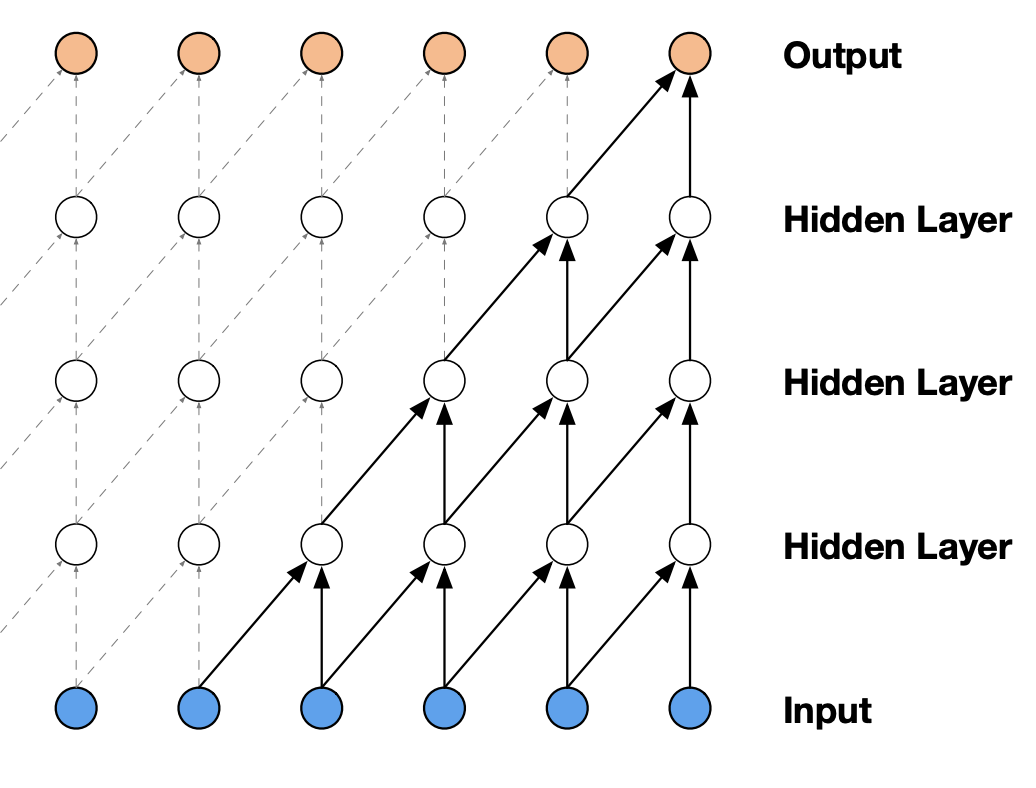

In [15]:
# it taken in 2 input then goes into a layer then its like a chain
#by far we've been using the dataset which is of [ n X no_of_grams_as_you've_decided X no_of_context window(in this case its 8)] and then we're flattening it to a 2d matrix [nXno_of_grams_as_you've_decided*no_of_context window(in this case its 8)]
#but now we'll use another class called flattenconsequtive

In [16]:
#there are 2 ways of turning a nxn//2xn*2
e= torch.randn((2,6,10)) #making a dataset similar to the pre-flatten dataset
e.shape

torch.Size([2, 6, 10])

In [17]:
#1:- taking the contatinating the even and odd elements 
k  =torch.cat([e[:,::2,:],e[:,1::2,:]],dim=2)
k.shape

torch.Size([2, 3, 20])

In [18]:
#2:- using the view function
A,B,C= e.shape
e =e.view(A,B//2,C*2)
e.shape

torch.Size([2, 3, 20])

In [19]:
(e==k).all()#as you can see we can use both of the methods but as we're more familiar with the view method we'll use view

tensor(True)

In [20]:
class FlattenConsequtive:
    def __init__(self,n):
        self.n = n
    def __call__(self,x):
        B,T,C =x.shape
        x =x.view(B,T//self.n,C*self.n)
        if x.shape[1] == 1:
            x=x.squeeze(1)
        self.out =x
        return self.out
    
    def parameters(self):
        return []
#and then we'll use this class instead of Flatten class 

In [21]:
#creating the embedding layer
torch.manual_seed(42)
dimension =10
vocab_size = len(int_string)
n_hidden =200
#C = torch.randn((vocab_size,dimension)) #removing this C because of that embedding class is doing that job in the layers list
model = sequencial([Embedding(vocab_size,dimension),FlattenConsequtive(2),Linear(dimension*2,n_hidden,bias=True),BatchNorm(n_hidden),Tanh(),
                    FlattenConsequtive(2),Linear(n_hidden*2,n_hidden,bias=True),BatchNorm(n_hidden),Tanh(),
                    FlattenConsequtive(2),Linear(n_hidden*2,n_hidden,bias=True),BatchNorm(n_hidden),Tanh(),
        Linear(n_hidden,vocab_size)])
#parameter init
with torch.no_grad():
    model.layers[-1].weight+=0.1# make the last layer less confident
parameters =model.parameters()
print(sum(p.nelement()for p in parameters))
for p in parameters:
    p.requires_grad=True



171497


In [22]:
ix = torch.randint(0,xtr.shape[0],(4,))
xb,yb = xtr[ix],ytr[ix]
logits = model(xb)
print(xb.shape)
xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0, 22,  9, 14, 14],
        [ 0,  0,  1, 13,  1, 12,  5,  5],
        [ 0,  0,  0, 13,  1, 18,  9,  6],
        [ 0,  0,  0,  0,  0, 10,  1,  5]])

In [23]:
for layer in model.layers:
    print(layer.__class__.__name__,":",tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsequtive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsequtive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsequtive : (4, 400)
Linear : (4, 200)
BatchNorm : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [30]:
#same optimizationas last time
epocs = 20000
batch_size =32
lossi=[]
for i in range(epocs):
    #mini batch 
    ix = torch.randint(0,xtr.shape[0],(batch_size,))
    Xb,Yb = xtr[ix],ytr[ix] #batch x,y
    #forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits,Yb)
    
    # backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    
    #updating simple SGD
    lr = 0.1 if i <15000 else 0.01
    for p in parameters:
        p.data +=-lr*p.grad
    #track the status
    if i%1000 ==0:
        print(f"{i:7d}/{epocs:7d}:{loss.item():4f}")
    lossi.append(loss.log10().item())

      0/  20000:3.429527
   1000/  20000:3.134304
   2000/  20000:2.305908
   3000/  20000:2.626716
   4000/  20000:2.662721
   5000/  20000:2.395228
   6000/  20000:2.191894
   7000/  20000:2.447719
   8000/  20000:2.373100
   9000/  20000:2.301814
  10000/  20000:2.574613
  11000/  20000:2.151944
  12000/  20000:2.241587
  13000/  20000:2.521554
  14000/  20000:2.307339
  15000/  20000:2.054931
  16000/  20000:2.314978
  17000/  20000:2.617043
  18000/  20000:2.793056
  19000/  20000:2.088699


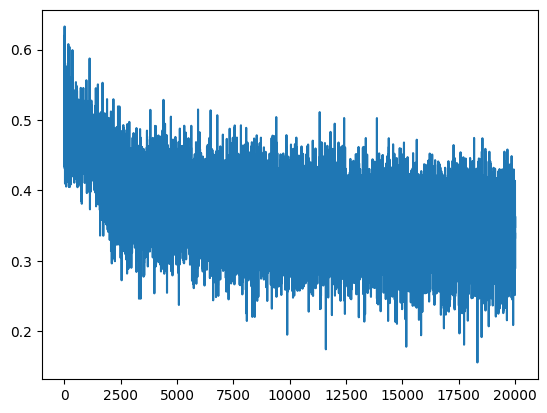

In [31]:
plt.plot(lossi)

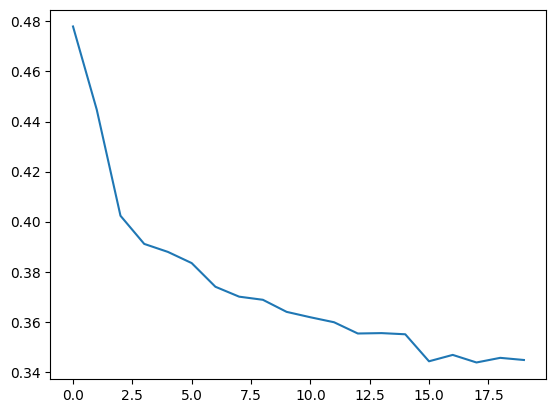

In [32]:
#making a new lossi graph just because we don't like the previous one
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [33]:
for layer in model.layers:
    layer.training=False

In [34]:
@torch.no_grad()
def split_loss(split):
    x,y ={
        "train":(xtr,ytr),
        "val":(xdev,ydev),
        "test":(xte,yte)
    }[split]
    logits = model(x)
    loss=F.cross_entropy(logits,y)
    print(split,loss.item())
split_loss("train")
split_loss("val")
loss

train 2.2186734676361084
val 2.220731735229492


tensor(2.2295, grad_fn=<NllLossBackward0>)

In [35]:
for _ in range(20):
    out=[]
    context = [0] *block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits,dim=1)
        #sample from the distribution
        ix = torch.multinomial(probs,num_samples=1).item()
        #shift the context window and track the smaple
        context=context[1:]+[ix]
        out.append(ix)
        if ix==0:
            break
    print("".join(int_string[i]for i in out))

casten.
jereji.
juca.
maithlo.
raya.
caydtynn.
sotas.
nysanssa.
kamim.
jatyng.
kelnna.
sellee.
nikaley.
mizaynus.
ylon.
caesto.
leellia.
cres.
drozia.
brittra.
